# Load model from .pb file

This code will load and return the graph.

* `model_file_name`: path to a `.pb` file.
* `node_mapping`: mapping from the name of node in the graph to a Tensorflow node in current session

In [1]:
import tensorflow as tf
from tensorflow.python.platform import gfile
def load_graph(sess, model_file_name, node_mapping={}):
    with gfile.GFile(model_file_name, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        tf.import_graph_def(graph_def, node_mapping)

This code will load the top-tagging model weights.

Please change the `model_file_name` to the file name of your model.

In [2]:
with tf.Session() as sess:
    # Create a placeholder for the input
    input_node = tf.placeholder(tf.float32, shape = [None, 224, 224, 3], name='Placeholder')
    graph_def = load_graph(sess=sess,
                           model_file_name='weights-floatingpoint-224x224-fixval-best/constantgraph.pb',
                           node_mapping={'Placeholder': input_node})
# Get the node for output
output_node = tf.get_default_graph().get_tensor_by_name("import/classifier/model_1/classifier_output/Softmax:0")

# Export to Tensorboard

This code will save the graph into a logging directory so that we can inspect it with Tensorboard.

* `log_dir_name`: Path to the directory that is used to store the log. You can use `tensorboard --logdir <log_dir_name>` to inspect the graph.

In [3]:
def write_to_log(log_dir_name):
    LOGDIR='log-top-tagging-resnet50-2'
    train_writer = tf.summary.FileWriter(log_dir_name)
    train_writer.add_graph(sess.graph)

This code will save the top-tagging model to a folder.

Please change the parameter to where you want to store the Tensorboad information.

In [4]:
write_to_log('log-top-tagging-resnet50')

# Run an inference

This code will run an inference on a matrix

In [5]:
import numpy as np
with tf.Session() as sess:
    y = sess.run(output_node, feed_dict={input_node: np.zeros((2, 224, 224, 3))})

In [6]:
print(y)

[[0.00170123 0.9982988 ]
 [0.00170123 0.9982988 ]]


# Evaluate model

Those are helper functions from [util.py](https://github.com/nhanvtran/MachineLearningNotebooks/blob/nvt/bwcustomweights-validate/project-brainwave/utils.py)

In [7]:
def normalize_and_rgb(images): 
    import numpy as np
    #normalize image to 0-255 per image.
    image_sum = 1/np.sum(np.sum(images,axis=1),axis=-1)
    given_axis = 0
    # Create an array which would be used to reshape 1D array, b to have 
    # singleton dimensions except for the given axis where we would put -1 
    # signifying to use the entire length of elements along that axis  
    dim_array = np.ones((1,images.ndim),int).ravel()
    dim_array[given_axis] = -1
    # Reshape b with dim_array and perform elementwise multiplication with 
    # broadcasting along the singleton dimensions for the final output
    image_sum_reshaped = image_sum.reshape(dim_array)
    images = images*image_sum_reshaped*255

    # make it rgb by duplicating 3 channels.
    images = np.stack([images, images, images],axis=-1)
    
    return images

In [8]:
def count_events(train_files):
    import tables
    n_events = 0
    for train_file in train_files:
        f = tables.open_file(train_file, 'r')
        n_events += f.root.label.shape[0]
        f.close()
    return n_events

In [9]:
def chunks(files, chunksize, max_q_size=4, shuffle=True): 
    """Yield successive n-sized chunks from a and b.""" 
    import tables
    import numpy as np
    for train_file in files: 
        f = tables.open_file(train_file, 'r') 
        nrows = f.root.label.nrows
        for istart in range(0,nrows,max_q_size*chunksize):  
            a = np.array(f.root.img_pt[istart:istart+max_q_size*chunksize]) # Images 
            b = np.array(f.root.label[istart:istart+max_q_size*chunksize]) # Labels 
            if shuffle: 
                c = np.c_[a.reshape(len(a), -1), b.reshape(len(b), -1)] # shuffle within queue size
                np.random.shuffle(c)
                test_images = c[:, :a.size//len(a)].reshape(a.shape)
                test_labels = c[:, a.size//len(a):].reshape(b.shape)
            else:
                test_images = a
                test_labels = b
            for jstart in range(0,len(test_labels),chunksize): 
                yield normalize_and_rgb(test_images[jstart:jstart+chunksize].copy()),test_labels[jstart:jstart+chunksize].copy(), len(test_labels[jstart:jstart+chunksize].copy())  
        f.close()

In [14]:
%matplotlib notebook
# In[33]:
test_loss_list = []
test_acc_list = []
def test_model(preds, in_images, test_files, chunk_size=64, shuffle=True):
    """Test the model"""
    import tensorflow as tf
    from keras import backend as K
    from keras.objectives import binary_crossentropy 
    import numpy as np
    from keras.metrics import categorical_accuracy
    from tqdm import tqdm
    
    in_labels = tf.placeholder(tf.float32, shape=(None, 2))
    
    cross_entropy = tf.reduce_mean(binary_crossentropy(in_labels, preds))
    accuracy = tf.reduce_mean(categorical_accuracy(in_labels, preds))
    auc = tf.metrics.auc(tf.cast(in_labels, tf.bool), preds)
   
    n_test_events = count_events(test_files)
    chunk_num = int(n_test_events/chunk_size)+1
    preds_all = []
    label_all = []
    
    sess = tf.Session()
    sess.run(tf.local_variables_initializer())
    
    avg_accuracy = 0
    avg_auc = 0
    avg_test_loss = 0
    epoch = 0
    epoch_list = []
    is_training = tf.get_default_graph().get_tensor_by_name('import/is_training:0')
    n_current_events = 0
    n_current_events = 0
    roc_curve = []
    for img_chunk, label_chunk, real_chunk_size in chunks(test_files, chunk_size, shuffle=shuffle):
        test_loss, accuracy_result, auc_result, preds_result = sess.run([cross_entropy, accuracy, auc, preds],
                        feed_dict={in_images: img_chunk,
                                   in_labels: label_chunk,
                                   K.learning_phase(): 0,
                                   is_training: False})
        avg_test_loss += float(test_loss * real_chunk_size / n_test_events)
        avg_accuracy += float(accuracy_result * real_chunk_size / n_test_events)
        avg_auc += auc_result[0]  * real_chunk_size / n_test_events  
        preds_all.extend(preds_result)
        label_all.extend(label_chunk)
        n_current_events += real_chunk_size
        test_loss_list.append( avg_test_loss*n_test_events/n_current_events)
        test_acc_list.append( avg_accuracy*n_test_events/n_current_events )
        roc_curve.append( avg_auc*n_test_events/n_current_events )
        if(epoch < 157 ):
            epoch += 1
            epoch_list.append(epoch)
        print("test_loss = ", "{:.3f}".format(avg_test_loss*n_test_events/n_current_events), end=" ")
        print("Test Accuracy:", "{:.3f}".format(avg_accuracy*n_test_events/n_current_events), " , Area under ROC curve:", "{:.3f}".format(avg_auc*n_test_events/n_current_events))
        print(epoch)
    
    import matplotlib.pyplot as plt
    print("+----Confusion Matrix----+")
    TP = 0
    FP = 0
    FN = 0
    TN = 0
    for i in range(len(label_all)):
        if ( (np.argmax(label_all[i],0) == 1) and (np.argmax(preds_all[i],0) == 1) ):
            TP += 1
        elif ( (np.argmax(label_all[i],0) == 0) and (np.argmax(preds_all[i],0) == 0)):
            TN += 1
        elif ( (np.argmax(label_all[i],0) == 0) and (np.argmax(preds_all[i],0) == 1)):
            FN += 1
        else:
            FP += 1
    TPR = TP/(TP+FN)
    FPR = FP/(FP+TN)
    print("TP: {0}, FP: {1}".format(TP,FP))
    print("FN: {0}, TN: {1}".format(FN,TN))
    print("+------------------------+")
    
    print("+------TPR and FPR-------+")
    print("TPR: {0:.3f}, FPR: {1:.3f}".format(TPR,FPR))
    print("+------------------------+")

    def plot_loss(x, y):
        plt.figure()
        plt.plot(x,y,label='test_loss')
        plt.xlabel('events')
        plt.ylabel('loss')
        plt.title('Loss per events.')
        plt.plot()
        #plt.savefig(figname)
    def plot_acc(x, y):
        plt.figure()
        plt.plot(x,y,label='test_acc')
        plt.xlabel('events')
        plt.ylabel('acc')
        plt.title('Accuarcy per events')
        plt.plot()
        #plt.savefig(figname)
    def roc_plot(x,y):
        xx = []
        for i in range(0,157):
            xx.append(x[i]/157)
        plt.figure()
        plt.plot(xx,y,label='ResNet-50(area = 0.958)')
        plt.plot(xx,xx,'--',label='Random')
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.legend(loc='lower right')
        plt.title('ROC curve.')
        plt.plot()
        #plt.savefig(figname)
    plot_loss(epoch_list, test_loss_list)
    plot_acc(epoch_list, test_acc_list)
    roc_plot(epoch_list, roc_curve)
    return avg_test_loss, avg_accuracy, avg_auc, np.asarray(preds_all).reshape(n_test_events,2), np.asarray(label_all).reshape(n_test_events,2)

This will test the model on a test file.

Please change the parameter so that it uses the correct file.

test_loss =  0.459 Test Accuracy: 0.875  , Area under ROC curve: 0.000
1
test_loss =  0.396 Test Accuracy: 0.883  , Area under ROC curve: 0.474
2
test_loss =  0.323 Test Accuracy: 0.896  , Area under ROC curve: 0.632
3
test_loss =  0.290 Test Accuracy: 0.906  , Area under ROC curve: 0.715
4
test_loss =  0.288 Test Accuracy: 0.900  , Area under ROC curve: 0.765
5
test_loss =  0.266 Test Accuracy: 0.906  , Area under ROC curve: 0.799
6
test_loss =  0.267 Test Accuracy: 0.911  , Area under ROC curve: 0.824
7
test_loss =  0.268 Test Accuracy: 0.908  , Area under ROC curve: 0.842
8
test_loss =  0.287 Test Accuracy: 0.901  , Area under ROC curve: 0.857
9
test_loss =  0.305 Test Accuracy: 0.892  , Area under ROC curve: 0.868
10
test_loss =  0.281 Test Accuracy: 0.901  , Area under ROC curve: 0.877
11
test_loss =  0.275 Test Accuracy: 0.902  , Area under ROC curve: 0.885
12
test_loss =  0.260 Test Accuracy: 0.906  , Area under ROC curve: 0.892
13
test_loss =  0.272 Test Accuracy: 0.904  , Area

<IPython.core.display.Javascript object>


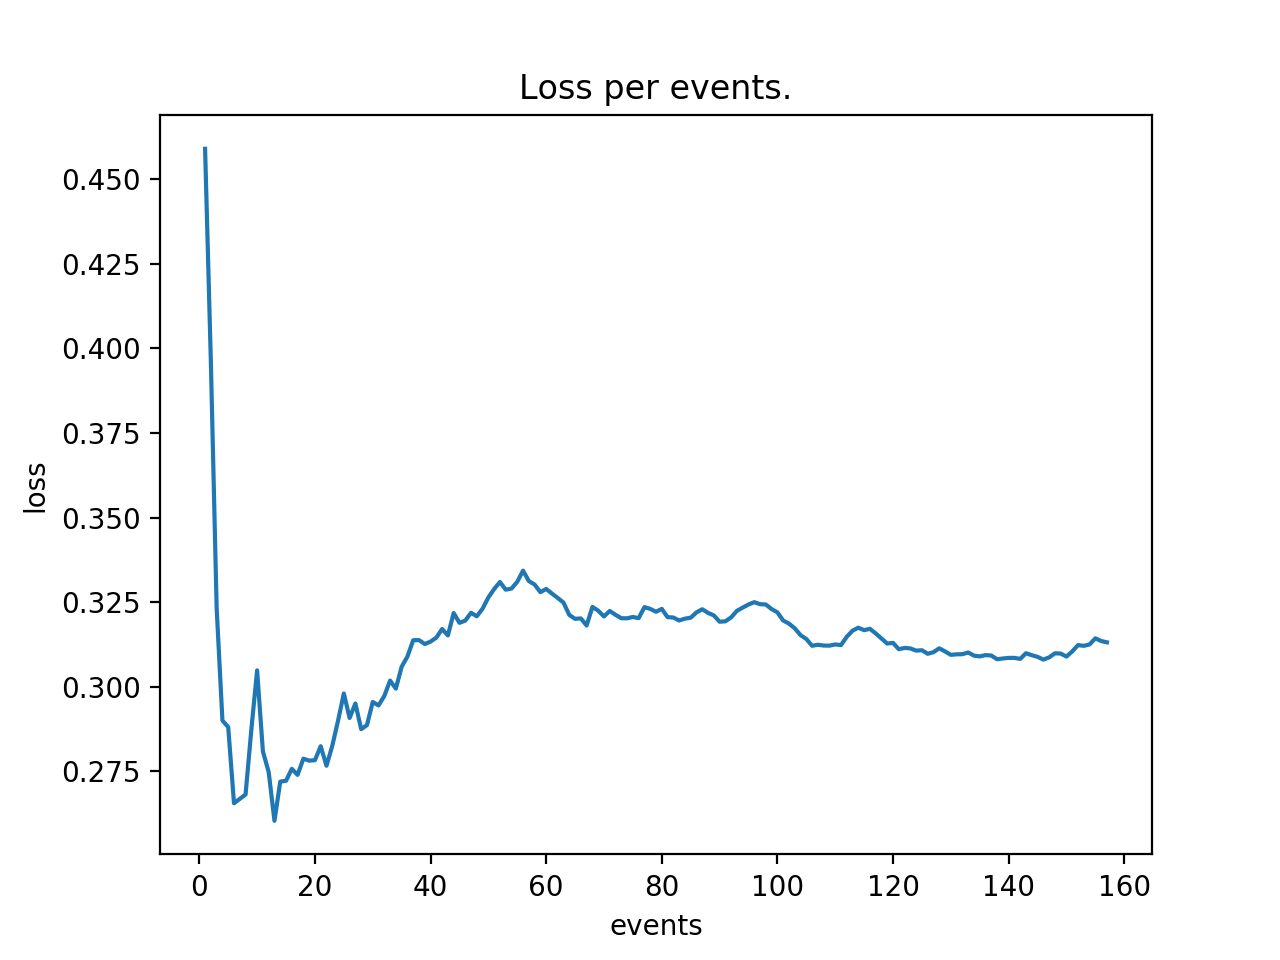

<IPython.core.display.Javascript object>


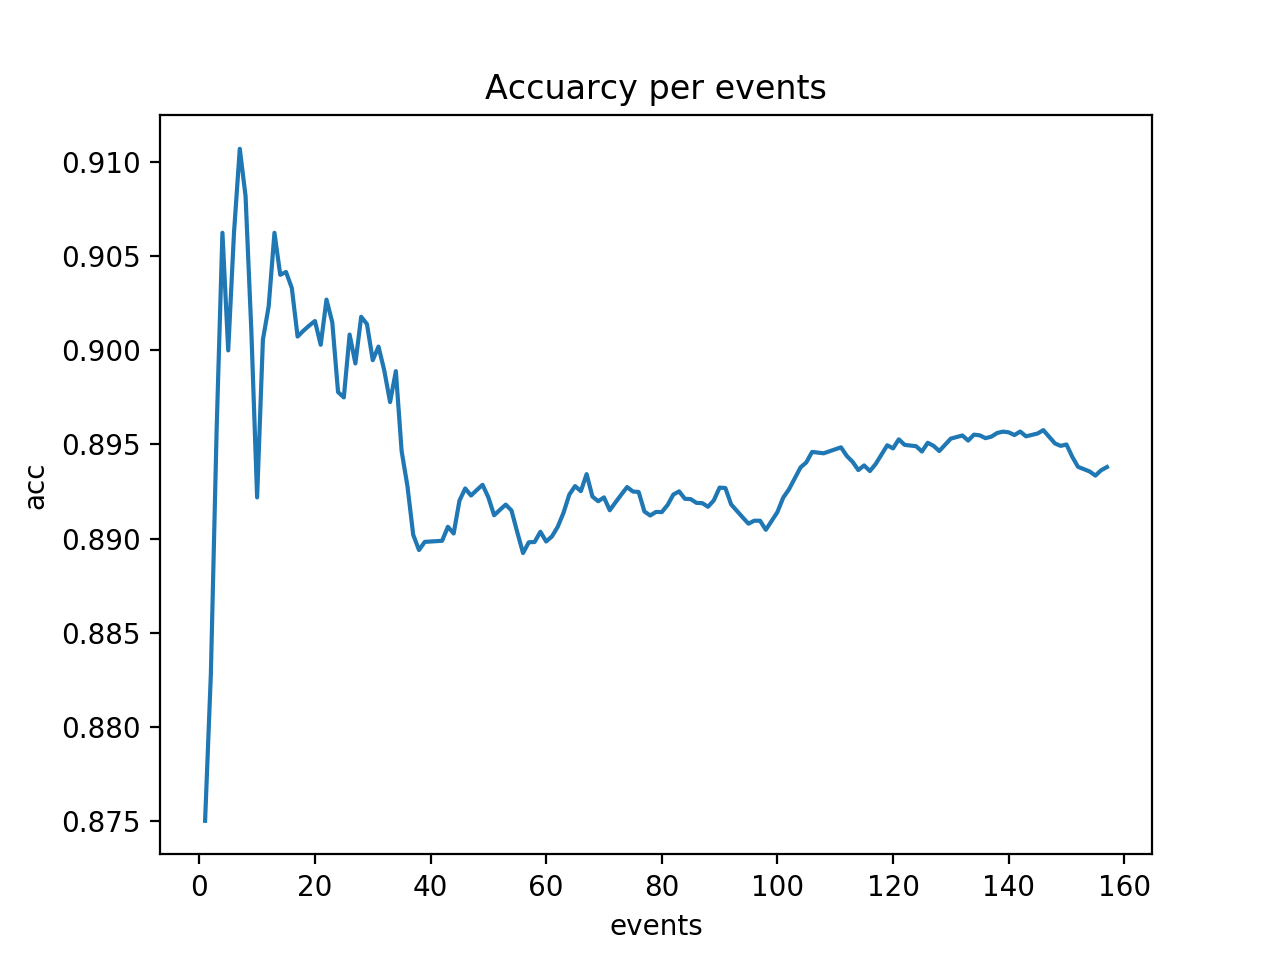

<IPython.core.display.Javascript object>


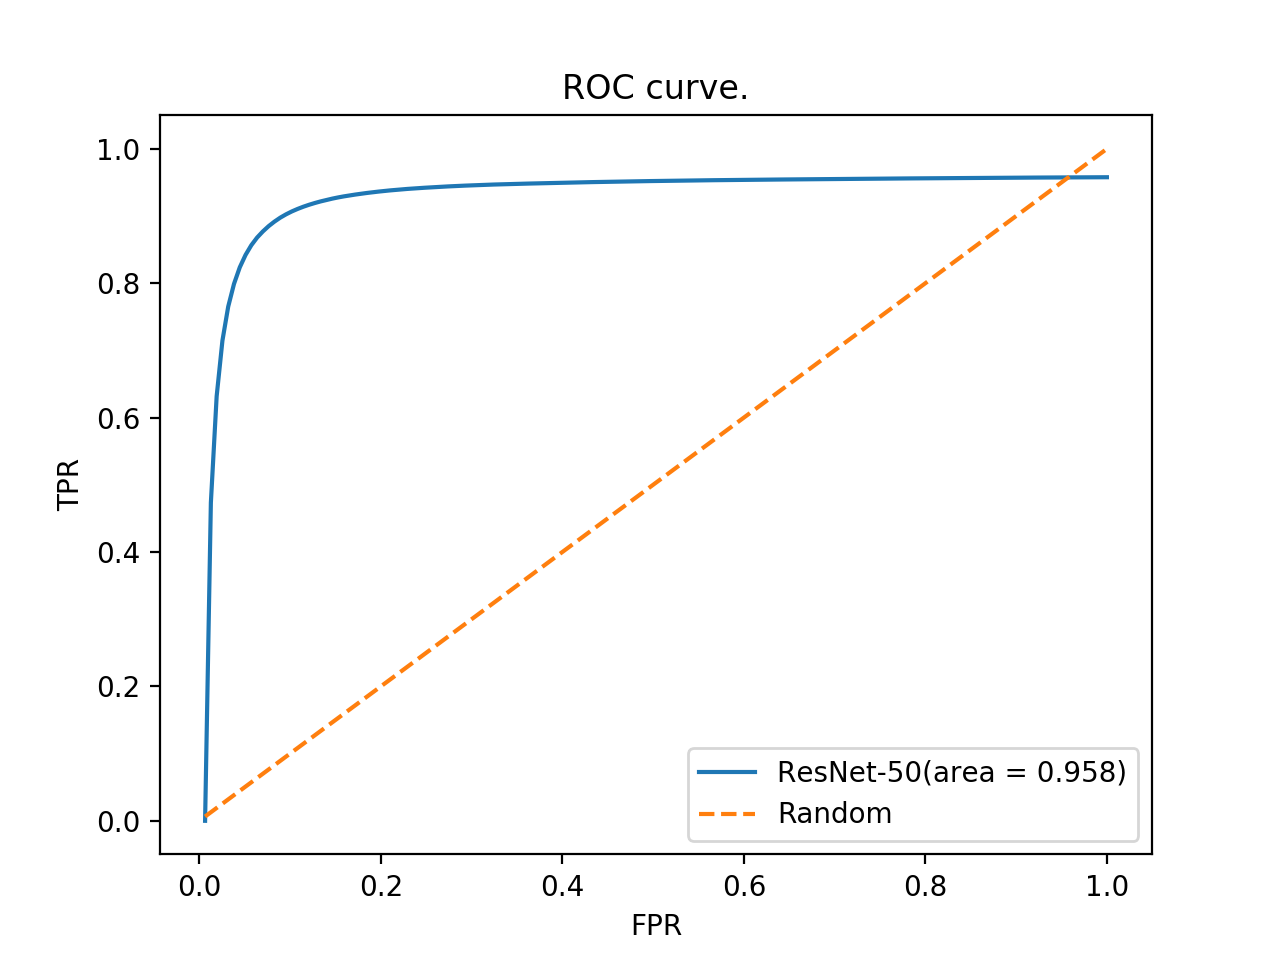

(0.3131051635026933,
 0.8938000000000005,
 0.9576883044242859,
 array([[9.9118209e-01, 8.8178487e-03],
        [1.3005758e-03, 9.9869943e-01],
        [9.0870954e-04, 9.9909127e-01],
        ...,
        [9.4619691e-01, 5.3803090e-02],
        [9.9911457e-01, 8.8545849e-04],
        [9.9992597e-01, 7.4013820e-05]], dtype=float32),
 array([[1., 0.],
        [0., 1.],
        [0., 1.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]]))

In [15]:
test_model(output_node, input_node, ['img224_all/converted/rotation_224_v1/test_file_0.h5'])

# Load model from .h5 file

Change `file_name` to the path of model.

In [16]:
import keras
file_name = 'weights-quantized-224x224-fixval-best-final/class_model_best.h5'
new_model = keras.models.load_model(file_name)
new_model.summary()










_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 1, 2048)        0         
_________________________________________________________________
dense_1 (Dense)              (None, 1, 1, 1024)        2098176   
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
classifier_output (Dense)    (None, 2)                 2050      
Total params: 2,100,226
Trainable params: 2,100,226
Non-trainable params: 0
_________________________________________________________________
